In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
from tqdm import tqdm
import random

In [3]:
import malaya

model = malaya.dependency.transformer(model = 'xlnet', quantized = True)
pos = malaya.pos.transformer(model = 'xlnet', quantized = True)

In [4]:
t = 'Dia suka membaca buku.'

In [5]:
tokenizer = malaya.preprocessing.TOKENIZER().tokenize
sastrawi = malaya.stem.sastrawi()

In [6]:
graph, tagging, indexing = model.predict(' '.join(tokenizer(t)))

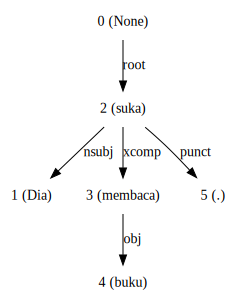

In [7]:
graph.to_graphvis()

In [8]:
pos.predict(' '.join(tokenizer(t)))

[('Dia', 'PRON'),
 ('suka', 'VERB'),
 ('membaca', 'VERB'),
 ('buku', 'NOUN'),
 ('.', 'PUNCT')]

In [9]:
malaya.stack.voting_stack([pos] * 3, ' '.join(tokenizer('Ahmad menendang bola itu.')))

[('Ahmad', 'PROPN'),
 ('menendang', 'VERB'),
 ('bola', 'NOUN'),
 ('itu', 'DET'),
 ('.', 'PUNCT')]

In [10]:
malaya.stack.voting_stack([pos] * 3, ' '.join(tokenizer('Dia memberi saya sebatang pena.')))

[('Dia', 'PRON'),
 ('memberi', 'VERB'),
 ('saya', 'PRON'),
 ('sebatang', 'DET'),
 ('pena', 'NOUN'),
 ('.', 'PUNCT')]

In [12]:
malaya.stack.voting_stack([pos] * 3, ' '.join(tokenizer('Dia memberikan sebatang pena kepada saya.')))

[('Dia', 'PRON'),
 ('memberikan', 'VERB'),
 ('sebatang', 'NOUN'),
 ('pena', 'NOUN'),
 ('kepada', 'ADP'),
 ('saya', 'PRON'),
 ('.', 'PUNCT')]

In [18]:
r = malaya.stack.voting_stack([pos] * 3, ' '.join(tokenizer(t)))

In [20]:
start_end = {'me': 'kan', 'mem': 'kan', 'men': 'kan', 'mem': '', 'me': '', 'men': ''}

def check_transitif(word):
    stemmed = sastrawi.stem(word)
    for k, v in start_end.items():
        if word.startswith(k) and word.endswith(v) and f'{k}{stemmed}{v}' == word:
            return True
    return False

In [24]:
import copy
import re
from malaya.text.regex import _expressions

def reset_t(tokens):
    t = []
    for i in range(len(tokens)):
        t.append([tokens[i], 2])
    return t

def augment_16_0(t, row):
    text, tokens, tokens_lower, tagging = row
    for i in range(len(tokens) - 1):
        if tagging[i] in ['PRON', 'NOUN'] \
        and tagging[i + 1] == 'VERB' \
        and tagging[i + 2] in ['PRON', 'NOUN'] \
        and check_transitif(tokens[i + 1]):
            t[i][1] = 16
            t[i + 1][0] = sastrawi.stem(tokens[i + 1])
            t[i + 1][1] = 16
            t[i + 2][1] = 16

In [25]:
results = []
for text in tqdm(['Cerpen itu telah saya karang.', 
                  'Latihan itu mesti kau buat.',
                  'Kereta itu saya beli daripada Ali.',
                  'Dia memberi saya sebatang pena.']):
    tokens = tokenizer(text)
    t = reset_t(tokens)
    t_ = copy.deepcopy(t)
    tokens_lower = tokenizer(text.lower())
    tagging = malaya.stack.voting_stack([pos] * 3, ' '.join(tokens))
    tagging = list(zip(*tagging))[1]
    r = (t, tokens, tokens_lower, tagging)
    augment_16_0(t_, r)
    results.append((t, t_))

100%|██████████| 4/4 [00:00<00:00,  5.00it/s]


In [26]:
results

[([['Cerpen', 2],
   ['itu', 2],
   ['telah', 2],
   ['saya', 2],
   ['karang', 2],
   ['.', 2]],
  [['Cerpen', 2],
   ['itu', 2],
   ['telah', 2],
   ['saya', 2],
   ['karang', 2],
   ['.', 2]]),
 ([['Latihan', 2],
   ['itu', 2],
   ['mesti', 2],
   ['kau', 2],
   ['buat', 2],
   ['.', 2]],
  [['Latihan', 2],
   ['itu', 2],
   ['mesti', 2],
   ['kau', 2],
   ['buat', 2],
   ['.', 2]]),
 ([['Kereta', 2],
   ['itu', 2],
   ['saya', 2],
   ['beli', 2],
   ['daripada', 2],
   ['Ali', 2],
   ['.', 2]],
  [['Kereta', 2],
   ['itu', 2],
   ['saya', 2],
   ['beli', 2],
   ['daripada', 2],
   ['Ali', 2],
   ['.', 2]]),
 ([['Dia', 2],
   ['memberi', 2],
   ['saya', 2],
   ['sebatang', 2],
   ['pena', 2],
   ['.', 2]],
  [['Dia', 16],
   ['beri', 16],
   ['saya', 16],
   ['sebatang', 2],
   ['pena', 2],
   ['.', 2]])]